# Training Reccurent Neural Networks <a class="anchor" id="top"></a>

This notebook was written by following the textbook of  Aurélien Géron's *Hands-On Machine Learning with Scikit-Learn and TensorFlow*, along with associated datasets ([Link to Github Repo](https://github.com/ageron/handson-ml/)). The contents in this notebook are my notes from reading the textbook.

### Notebook by Justin Bandoro`

Recurrent neural networks (RNNs) are a class of nets that can predict the future. They can analyze time series data such as stock prices, and tell you when to buy/sell. In autonomous driving systems, they can anticipate car trajectories and help avoid accidents. More generally, they can work on sequences of arbitrary lengths, rather than on fixed-sized inputs like all the nets discussed so far. For example they can take sentences, documents or audio samples as inputs and are extremely useful in natural language parocessing systems. 

In this chapter we will look at the fundamental concepts underlying RNNs and the main problems they face (vanishing/exploding gradients) and the solutions to fight it: LSTM and GRU cells. 

In [1]:
# Load modules
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as sio
from matplotlib import cm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

### Viewing TensorBoard in Jupyter
Quick script to view our graphs in the notebook.

In [2]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:350px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:800px;height:400px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

## 1. Recurrent Neurons <a class="anchor" id="recurrent"></a>

Up to now, all of the ANNs have been feedforward neural networks, where the activations flow only in one direction, from input layer to the output layer. A recurrent neural network looks like a feedforward neural network except it also has connections pointing backward. The simplest possible RNN is shown below, with one neuron receiving inputs, producing an output and sending that ouput back to itself.



<img src='rnn.png'> 

At each time step, $t$ (also called a frame), the recurrent neuron receives the inputs $\textbf{x}_{(t)}$ as well as its own output from the previous step, $y_{(t-1)}$. This is called unrolling the network through time. 

You can also easily create a layer of recurrent neurons. At each time step, $t$, every neuron receives both the input vector $\textbf{x}_{(t)}$ and the output vector from the previous time step $\textbf{y}_{(t-1)}$ as shown in the figure below. 

<img src='rnn2.png'> 

Note that both the inputs and outputs are vectors now (when there was just a single neuron, the output was a scalar). Each reccurent neuron has 2 sets of weights: one for the inputs $\textbf{x}_{(t)}$ and the other for the outputs of the previous time step, $\textbf{y}_{(t-1)}$. Let's call these weight vectors $\textbf{w}_{x}$ and $\textbf{w}_{y}$. The output of a single recurrent neuron can be computed as expected:

$\textbf{y}_{(t)} = \phi( \textbf{x}_{(t)}^T \cdot \textbf{w}_{x} + \textbf{y}_{(t-1)}^T \cdot \textbf{w}_{y} + b)$

where $b$ is the bias term and $phi$ is the activation function (e.g. ReLU) for a single instance. Similar to feedforward neural networks, you can compute a whole layer's output in one shot for a whole mini-batch using a vectorized form of the previous equation.

$\textbf{Y}_{(t)} = \phi( \left[ \textbf{X}_{(t)},\textbf{Y}_{(t-1)}\right]\textbf{W} + \textbf{b}), with \textbf{W} = \left[ \begin{array}{c}
\textbf{W}_{x} \\
\textbf{W}_{y}  \end{array} \right] $

* $\textbf{Y}_{(t)}$ is a $m\times n_{neurons}$ matrix containing the layer's outputs at time step $t$ for each instance in the mini-batch ($m$ is the number of isntance sin the mini-batch)
* $\textbf{X}_{(t)}$ is a $m\times n_{inputs}$ matrix containing the inputs for all instances ($n_{inputs}$ is the number of input features).
* $\textbf{W}_{x}$ is a $n_{inputs}\times n_{neurons}$ matrix containing the connection weights for the inputs of the current time step.
* $\textbf{W}_{y}$ is a $n_{neurons}\times n_{neurons}$ matrix containing the connection weights for the outputs of the previous time step.
* The weight matrices are often concatenated into a single weight matrix $\textbf{W}$ of shape $(n_{inputs} + n_{neurons})\times n_{neurons}$ .
* $\textbf{b}$ is a bias vector of size $n_{neurons}$ containing each neuron's bias term.

$\textbf{Y}_{(t)}$ is a function of both $\textbf{X}_{(t)}$ and $\textbf{Y}_{(t-1)}$, which is a function of $\textbf{X}_{(t-1)}$ and $\textbf{Y}_{(t-2)}$ and so on. This makes $\textbf{Y}_{(t)}$ a function of all the inputs since time $t=0$. 

### Memory Cells

Since the output of a recurrent neuron at time step $t$ is a function of all the inputs from previous time steps, you could say it has a form of memory. The part of the neural network that preserves some state across time steps is called a memory cell. A single recurrent neuron, or a layer of recurrent neurons is a very basic cell, but later in this chapter we will look at some more complex and powerful types of cells.

A cell's state at time $t$ is denoted $\textbf{h}_{(t)}$ (the h stands for hidden) is a function of some inputs at that time step and its state at the previous time step: $\textbf{h}_{(t)} = f(\textbf{h}_{(t-1)},\textbf{x}_{(t)})$. Its output at time step $t$ is denoted $\textbf{y}_{(t)}$ is also a function of the previous state and the current inputs. In a simple basic cell, the output is equal to the state but in more complex cells this is not always the case.

<img src='memorycell.png'>

### Input and Output Sequences

An RNN can simultaneously take a sequence of inputs and produce a sequence of outputs. For example, this type of network is useful for predicting time series such as stock prices: you feed it the prices over the last $N$ days and it put output the prices shifted by one day into the future (i.e. from $N-1$ days ago to tomorrow. (see top left below).

You could also feed the network a sequence of inputs, and ignore all outputs except for the last one (see top right below). This is a sequence-to-vector network. For example, you could feed the network a sequence of words corresponding to a movie review, and the network would output a sentiment score (e.g. -1 to +1). 

Conversely, you could feed the network a single input at the first time step (and zeros for all other time steps), and let it output a sequence (see bottom left below). This is a vector-to-sequence network. For example the input could be a image and the outpu t could be  a caption for that image.

Lastly you could have a sequence-to-vector network called an encoder followed by a vector-to-squence network, called a decorder (see bottom right below). This can be used for translating a sentence from one language to another. YOu would feed the network a sentence in one language, the encoder would convert this senstence into a single vector representation, and then the decoder would decode this vector into a sentence in another language. This type of model called Encoder-Decoder works much better than trying to translate on the fly with a single sequence-to-sequence RNN (top left) since the last words of the sentence can affect the first words of the translation.

<img src='sequence.png'>

## 2. Basic RNNs in Tensor Flow <a class="anchor" id="basic"></a>

Below we will implement a simple RNN model without using TF's operations to better understand what is going on. We will make a RNN of a layer of 5 recurrent neurons using the hyperbolic tan activation function. We will assume that the RNN runs over only two time steps, taking input vectors of size 3 at each time step. Teh following code builds this RNN unrolled through 2 time steps:

In [8]:
tf.reset_default_graph()
n_inputs = 3
n_neurons= 5

X0 = tf.placeholder(tf.float32,[None,n_inputs],name='XO')
X1 = tf.placeholder(tf.float32,[None,n_inputs],name='X1')
Wx = tf.Variable(tf.random_normal(shape=[n_inputs,n_neurons],dtype=tf.float32),name='Wx')
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32),name='Wy')
b  = tf.Variable(tf.zeros([1,n_neurons]),dtype=tf.float32,name='b')

Y0 = tf.tanh(tf.matmul(X0,Wx)+b,name='Y0')
Y1 = tf.tanh(tf.matmul(Y0,Wy)+ tf.matmul(X1,Wx) + b ,name='Y1')
init = tf.global_variables_initializer()

The same weights and bias terms are shared by both layers, and we feed inputs at each layer and we get outputs from each layer. To run the model we need to feed it the inputs at both time steps, like follows. This mini-batch contains 4 instances each with an input sequence composed of exactly 3 inputs.

In [10]:
#Mini-batch: instance 0, instance 1, instance 2, instance 3
X0_batch = np.array([[0,1,2],[3,4,5],[6,7,8],[9,0,1]])
X1_batch = np.array([[9,8,7],[6,5,4],[3,2,1],[0,0,0]])

with tf.Session() as sess:
    init.run()
    Y0_val,Y1_val = sess.run([Y0,Y1],feed_dict={X0:X0_batch,X1:X1_batch})

At the end, `Y0_val` and `Y1_val` contain the outputs of the network at both time steps for all neurons and all instances in the mini-batch:

In [12]:
print('t=0 :'); [print('   instance{}: {}'.format(i,ins)) for i,ins in enumerate(Y0_val)]
print('t=1 :'); [print('   instance{}: {}'.format(i,ins)) for i,ins in enumerate(Y1_val)]

t=0 :
   instance0: [ 0.97768724  0.40165904  0.99455971  0.97558522  0.91249096]
   instance1: [ 0.96285772  0.99984038  1.          0.99998045  0.99968421]
   instance2: [ 0.93847841  1.          1.          1.          0.99999881]
   instance3: [-0.83357799  1.          0.99968946 -0.99280703  0.9905178 ]
t=1 :
   instance0: [-0.98546553  1.          1.          0.99997216  0.99998987]
   instance1: [-0.96263003  0.99999988  1.          0.88691479  0.99679822]
   instance2: [-0.93739516  0.99920106  0.99988717 -0.97616708  0.37057504]
   instance3: [ 0.10039583  0.97427726  0.99979991 -0.96799183  0.94102269]


[None, None, None, None]

### Static Unrolling Through Time
The `static_rnn()` function creates an unrolled RNN network by chaning cells. The following code creates the exact same model as the previous one:

In [17]:
tf.reset_default_graph()

X0 = tf.placeholder(tf.float32,[None,n_inputs],name='XO')
X1 = tf.placeholder(tf.float32,[None,n_inputs],name='X1')

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell,[X0,X1],dtype=tf.float32)

Y0,Y1= output_seqs

We first create input placeholders, and then create a `BasicRNNCell` which is like the factory that creates copies of the cell to build the unrolled RNN (one for each time step). Then we call `static_run()` giving it the cell factory and the input tensors, and telling it the data type of the inputs (this is used to create the initial state matrix, which by default is full of zeros). The `static_run()` function calls the cell's factory's `__call__()` function once per input, creating 2 copies of the cell (each containing a layer of five recurrent neurons), with shared weights and bias terms and it chains them just like we did earlier. The `static_run()` function returns 2 objects: the first is a python list containing the output tensors for each time step, and the second is tnesor containing the final states of the network. For basic cells, the final state is equal to the last output.

If we had 50 time steps, it would not be convenient to define 50 input placeholders and 50 output tensors. At execution you would have to feed each of the 50 placeholders and manipulate the 50 outputs. This can be simplified. The following code builds the same RNN again, but thsi time takes a single input placeholder of shape `[None, n_steps, n_inputs]` where the first dimension is the mini-batch size. Then it extracts the list of input sequences for each time step. `X_seqs` is a list `n_steps` tensors of shape `[None, n_inputs]` where once again the first dimension is the mini-batch size. To do this, we first swap the first 2 dimensions using `transpose()` so that time steps are now the first dimension. Then we extract a list of tensors along the first dimension (i.e., one tensor per time step) using `unstack()` function. The next 2 lines are the same as before. Finally we merge all the output ensors into a single tensor using `stack()` function , and we swap the first 2 dimensions to get a final `outputs` tensor of shape `[None, n_steps, n_neurons]`. 

In [20]:
tf.reset_default_graph()

n_steps = 2
X = tf.placeholder(tf.float32,[None,n_steps,n_inputs])
X_seqs = tf.unstack(tf.transpose(X,perm=[1,0,2]))
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs,states = tf.contrib.rnn.static_rnn(basic_cell,X_seqs,dtype=tf.float32)

outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

Now we can run the network by feeding it a single tensor that contains all the mini-batch sequences:

In [22]:
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})
outputs_val.shape

(4, 2, 5)

The output is a single tensor for all instances, all time steps and all neurons. However this approach still builds a graph containing one cell per time step and the graph could look ugly. There is a better solution of `dynamic_rnn()`.

### Dynamic Unrolling Through Time

The `dynamic_rnn()` uses a `while_loop()` operation to run over the cell the appropriate number of times, and you can set `swap_memory=True` to wap the GPU's memory to the CPU's memory during backpropagation. It also accepts a single tensor for all inputs at every time step (shape `[None,n_steps,n_inputs]`) and it outputs a single tensor for all outputs at every time step (shape `[None,n_steps,n_neurons]`); there is no need to stack/unstack or transpose. The following code creates the same RNN as earlier using the `dynamic_rnn()` function:

In [26]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
init = tf.global_variables_initializer()

X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

outputs_val.shape
show_graph(tf.get_default_graph())

### Handling Variable Length Input Sequences

The examples above were for fixed-size input sequences (all exactly 2 steps long). If the input sequences have variable lengths (e.g. sentences) then the parameter `sequence_length` can be set in `dynamic_rnn()`. It must be a 1D tensor indicating the length of the input sequence for each instance.

In [29]:
tf.reset_default_graph()

X   = tf.placeholder(tf.float32,[None,n_steps,n_inputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
#Sequence length
seq_length= tf.placeholder(tf.int32,[None])
outputs,states = tf.nn.dynamic_rnn(basic_cell,X,dtype=tf.float32,sequence_length=seq_length)

init=tf.global_variables_initializer()

X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 padded w/ zeros
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
batch_seq_length = np.array([2,1,2,2])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch,seq_length:batch_seq_length})
print(outputs_val)

[[[-0.77342463 -0.47699311 -0.40117687 -0.0260131   0.08282632]
  [-0.99988914 -0.51245546 -0.99901086  0.99999821 -0.97095728]]

 [[-0.9948616  -0.77624899 -0.94690007  0.97817075 -0.56791639]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.99989617 -0.91422009 -0.99652475  0.99976873 -0.87912452]
  [-0.99891728  0.57754749 -0.98053443  0.99983096 -0.27161852]]

 [[ 0.87574071  0.26881176  0.11159906  0.99974692 -0.99333119]
  [-0.91324788  0.03303874 -0.6409052   0.97427315 -0.04320927]]]


The second input above contains only one input instead of two and is padded with a zero vector, and the RNN outputs zero vectors for every time step past the input sequence length. The `states` vector will contain the final state of each cell with the 2nd input being at $t=0$ and all the other ones of $t=1$.

### Handling Variable Length Output Sequences

What if the output sequences have variable lengths as well, if it is known in advance then you can set the `sequence_length` parameter as before. But is not possible for example if using translation as you don't know the length of the translated sentence before. The common solution is to define a special output called *end-of-sequence token* (EOS token). Any output past the EOS should be ignored.

## 3. Training RNNs <a class="anchor" id="training"></a>

The key for training RNNs is to unroll it through time (like we just did) and then simply use regular backpropagation. This strategy is called backpropagation through time (BPTT).

<img src='bptt.png'>

Similar to regular backpropagation, there is first a forward pass through the unrolled network (represented above by the dashed arrows) then the output sequence is evaluated using a cost funcion:

$\textbf{C} \left( \textbf{Y}_{(t_{min})},\textbf{Y}_{(t_{min}+1)},\cdots,\textbf{Y}_{(t_{max})}  \right)$

where $(t_{min}$ and $(t_{max}$ are the first and last output time steps, not counting the ignored outputs. The gradients of the cost function are propagated backward through the unrolled network (represented by solid arrows), and finally the model parameters are updated using the gradients computed during BPTT. 

### Training a Sequence Classifier

We will train an RNN to classify MNIST images. We will treat each image as a sequence of 28 rows of 28 pixels each. We will use cells of 150 recurrent neurons plus a fully connected layer containing 10 neurons (one per class) connected to the output of the last time step.

<img src='mnist_rnn.png'>

The construction is similar to the FNN except that an unrolled RNN replaces the hidden layers. Note that the fully connected layer is connected to the `states` tensor which contains only the final state of the RNN (the 28th output). Note that `y` is a placeholder for the target class.

In [40]:
tf.reset_default_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

eta = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=eta)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

With the graph constructed we will fetch MNIST data. MNIST training data is reshaped into `[batch_size,n_steps,n_inputs]`.

In [41]:
from tensorflow.examples.tutorials.mnist import input_data
# MNIST data
mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1,n_steps,n_inputs))
y_test = mnist.test.labels

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Now we are ready for the execution phase, the only difference between this and FNN is that we will reshape the training data.

In [42]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.953333 Test accuracy: 0.9403
1 Train accuracy: 0.933333 Test accuracy: 0.9392
2 Train accuracy: 0.933333 Test accuracy: 0.9539
3 Train accuracy: 0.953333 Test accuracy: 0.9576
4 Train accuracy: 0.966667 Test accuracy: 0.9633
5 Train accuracy: 0.98 Test accuracy: 0.9678
6 Train accuracy: 0.966667 Test accuracy: 0.9669
7 Train accuracy: 0.993333 Test accuracy: 0.9679
8 Train accuracy: 0.98 Test accuracy: 0.9716
9 Train accuracy: 0.993333 Test accuracy: 0.9739
10 Train accuracy: 0.953333 Test accuracy: 0.9731
11 Train accuracy: 0.973333 Test accuracy: 0.9756
12 Train accuracy: 0.98 Test accuracy: 0.96
13 Train accuracy: 0.966667 Test accuracy: 0.9706
14 Train accuracy: 0.973333 Test accuracy: 0.9687
15 Train accuracy: 0.986667 Test accuracy: 0.9746
16 Train accuracy: 0.993333 Test accuracy: 0.974
17 Train accuracy: 1.0 Test accuracy: 0.9677
18 Train accuracy: 0.993333 Test accuracy: 0.9763
19 Train accuracy: 0.986667 Test accuracy: 0.9795
20 Train accuracy: 0.986667 Te

### Training to Predict Time Series
We can now look at how to handle time series data, such as stock prices, air temperature, brain wave patterns, and so on. In this example will train an RNN to predict the next value in a generated time series. Each training instance is a randomly selected sequence of 20 consecutive values from the time series. The target series is the same as the input sequence except shifted by one time step into the future.

In [59]:
t_min,t_max = 0,30
resolution = 0.1
def time_series(t):
    return t*np.sin(t)/3 + 2*np.sin(t*5)

def next_batch(batch_size,n_steps):
    # Select random start points in the time series to start for n_batches
    t0 = np.random.rand(batch_size,1)*(t_max-t_min-n_steps*resolution)
    Ts = t0 + np.arange(0,n_steps+1)*resolution
    ys = time_series(Ts)
    return ys[:,:-1].reshape(-1,n_steps,1), ys[:,1:].reshape(-1,n_steps,1)

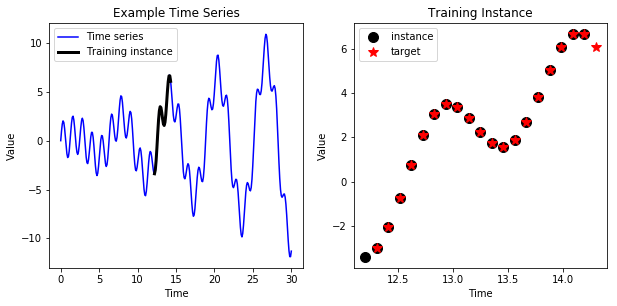

In [45]:
# Plotting time series
t = np.linspace(t_min,t_max,int((t_max-t_min)/resolution))
n_steps = 20 # number of time steps for a training instance
t_instance = np.linspace(12.2,12.2+resolution*(n_steps+1),n_steps+1)
fig,(ax1,ax2) = plt.subplots(1,2, figsize=[10,4.5])
ax1.plot(t,time_series(t),label='Time series',color='b')
ax1.plot(t_instance,time_series(t_instance),label='Training instance',color='k',linewidth=3.0)
[ax.set_xlabel('Time') for ax in [ax1,ax2]]; [ax.set_ylabel('Value') for ax in [ax1,ax2]]
ax1.set_title('Example Time Series')
ax2.plot(t_instance[:-1],time_series(t_instance[:-1]),'ko',markersize=10,label='instance')
ax2.plot(t_instance[1:],time_series(t_instance[1:]),'r*',markersize=10,label='target')
ax2.set_title('Training Instance')
[ax.legend() for ax in [ax1,ax2]]

As shown above the target is one time step in the future.

Below we create a RNN containing 100 recurrent neurons and unroll it over 20 time steps since each training instance will be 20 inputs long. Each input only contains one feature (the value at the time). The target is also a sequence of 20 inputs (each containing a single value). 

In [110]:
tf.reset_default_graph()

n_steps = 20
n_inputs= 1
n_neurons= 100
n_outputs= 1

X = tf.placeholder(tf.float32,[None,n_steps,n_inputs])
y = tf.placeholder(tf.float32,[None,n_steps,n_outputs])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons,activation=tf.nn.relu)
outputs,states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

> In general you would have more than just one input feature. For example, if you were trying to predict stock prices, you would likely have many other input features at each time step, such as prices of competing stocks, ratings from analysts, or other features that would help make predictions.

Above we see that `outputs` is tensor at each time step with a size of 100. But we want a single output value at each time step. The solution is to wrap the cell in an `OutputProjectionWrapper`. A cell wrapper acts like a normal cell, proxying every method call to and underlying cell but adds functionality. The `OutputProjectionWrapper` adds a fully connected layer of linear neurons (i.e no activation function) on top of each output (but does not affect the cell state). All of these connected layers share the same (trainable) weights and bias terms.

We will change the previous code to wrap the `BasicRNNCell`:

In [111]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32,[None,n_steps,n_inputs])
y = tf.placeholder(tf.float32,[None,n_steps,n_outputs])

cell = tf.contrib.rnn.OutputProjectionWrapper( 
                tf.contrib.rnn.BasicRNNCell(num_units=n_neurons,activation=tf.nn.relu),
                output_size=n_outputs)
    
outputs,states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

Next we need to define a cost function, we will use the MSE for this problem. We will use an Adam optimizer to minimize the MSE.

In [112]:
eta = 0.01

#Cost function
mse = tf.reduce_mean( tf.square(outputs-y))
#Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = eta)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

#Execution
n_iterations = 1000
batch_size = 50
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch,y_batch = next_batch(batch_size,n_steps)
        sess.run(training_op,feed_dict={X:X_batch,y:y_batch})
        if iteration % 100 == 0:
            mse_val = mse.eval(feed_dict={X:X_batch,y:y_batch})
            print(iteration, ' MSE: ',mse_val)
    saver.save(sess,"./my_time_series_model")

0  MSE:  6.74509
100  MSE:  0.0677605
200  MSE:  0.0568383
300  MSE:  0.047159
400  MSE:  0.0449793
500  MSE:  0.0449349
600  MSE:  0.0451545
700  MSE:  0.0498694
800  MSE:  0.0390821
900  MSE:  0.0485487


With the trained model we can now make predictions, let's look at the same instance we had earlier:

In [113]:
with tf.Session() as sess:
    saver.restore(sess,'./my_time_series_model')
    X_new = time_series(t_instance[:-1].reshape(-1,n_steps,n_inputs))
    y_pred = sess.run(outputs,feed_dict={X:X_new})    

INFO:tensorflow:Restoring parameters from ./my_time_series_model


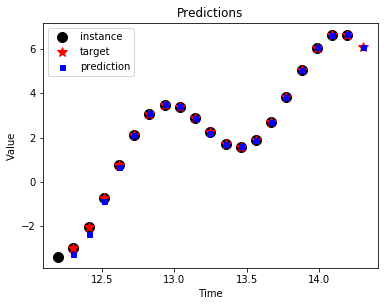

In [75]:
# Plotting predictions
fig,(ax1) = plt.subplots(1,1, figsize=[6,4.5])
ax1.set_xlabel('Time'); ax1.set_ylabel('Value');ax1.set_title('Predictions')
ax1.plot(t_instance[:-1],time_series(t_instance[:-1]),'ko',markersize=10,label='instance')
ax1.plot(t_instance[1:],time_series(t_instance[1:]),'r*',markersize=10,label='target')
ax1.plot(t_instance[1:],y_pred[0,:,0],'bs',markersize=5,label='prediction')
ax1.legend()

While using `OutputProjectionWrapper` is the simplest solution to reduce the dimensionality of the RNN's output sequences down to a single value per time step (per instance) it is not efficient.

One solution is reshape the RNN outputs from `[batch_size, n_steps, n_neurons]` to `[batch_size*n_steps,n_neurons]` then apply a single fully connected layer with the appropriate output size (here just 1) which will result in an output tensor of shape `[batch_size*n_steps,n_outputs]` and then reshape this tensor to `[batch_size,n_steps,n_outputs]`. This can provide a speed boost since there is only one fully connected layer per time step.

### Without using `OutputProjectionWrapper`

In [98]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32,[None,n_steps,n_inputs])
y = tf.placeholder(tf.float32,[None,n_steps,n_outputs])

cell =   tf.contrib.rnn.BasicRNNCell(num_units=n_neurons,activation=tf.nn.relu)         
rnn_outputs,states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

# NEW PARTft
stacked_rnn_outputs = tf.reshape(rnn_outputs,[-1,n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs,n_outputs)
outputs = tf.reshape(stacked_outputs,[-1,n_steps,n_outputs])

eta = 0.01

#Cost function
mse = tf.reduce_mean( tf.square(outputs-y))
#Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = eta)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

#Execution
n_iterations = 1000
batch_size = 50
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch,y_batch = next_batch(batch_size,n_steps)
        sess.run(training_op,feed_dict={X:X_batch,y:y_batch})
        if iteration % 100 == 0:
            mse_val = mse.eval(feed_dict={X:X_batch,y:y_batch})
            print(iteration, ' MSE: ',mse_val)
    saver.save(sess,"./my_time_series_model")

0  MSE:  14.3132
100  MSE:  0.119535
200  MSE:  0.056038
300  MSE:  0.0470315
400  MSE:  0.051036
500  MSE:  0.0464985


### Generating New Sequences

Now that we have a model that can predict the future, we can use it to generate some creative sequences, as explained at the beginning fo the chapter. All we need to do is provide it a seed sequence containing `n_steps` values (e.g. full of zeros) and use the model to predict the next value, append this predicted value to the sequence, feed the last `n_steps` values to the model to predict the next value, and so on. 

This process generates a new sequence that has some resemblance to the original time series. Below we will use the same example as before, but use the training instance as our series to sequentially keep predicting from and then we how well it matches the original time series.

In [114]:
# Load in saved model and lets take the same instance we had earlier as our 20 steps
t_sequence = t_instance[1:]
n_predict  = 50 # new time series to predict
with tf.Session() as sess:                        
    saver.restore(sess, "./my_time_series_model") 
    sequence = time_series(t_sequence)
    for iteration in range(50):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence = np.append(sequence, y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./my_time_series_model


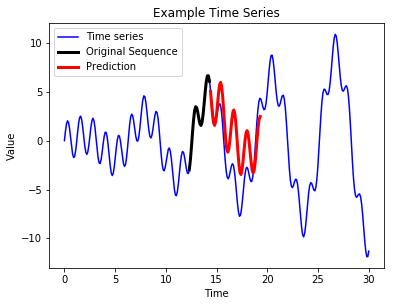

In [115]:
# Plotting time series
fig,ax1 = plt.subplots(1,1, figsize=[6,4.5])
ax1.plot(t,time_series(t),label='Time series',color='b')
ax1.plot(t_sequence,time_series(t_sequence),label='Original Sequence',color='k',linewidth=3.0)
ax1.set_xlabel('Time') ; ax1.set_ylabel('Value')
ax1.set_title('Example Time Series')
t_squence_predict = t_sequence[-1] + np.arange(1,n_predict+1)*resolution
ax1.plot(t_squence_predict,sequence[-n_predict:],'r',linewidth=3.0,label='Prediction')
ax1.legend()

## License

The material in this notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by-nc/4.0/).